In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
!apt install coinor-libipopt-dev
!pip install ipopt
import ipopt

!pip install cplex
import cplex

# Implement investment strategies

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   interest = 0
   x_optimal = x_init
   cash_optimal = cash_init   
   return x_optimal, cash_optimal, interest

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    interest = 0
    # Number of stocks
    n = 20
    # Equally weighted
    weights = 1/n
    # Portfolio value formula
    portf_value = np.dot(x_init, cur_prices) + cash_init 
    
    # Round down for the number of shares
    x_optimal = np.floor(portf_value * weights / cur_prices)
    # Transaction cost
    trans_cost = 0.005 * np.dot(abs(x_optimal - x_init), cur_prices)
    # Cash formula
    cash_optimal = portf_value - np.dot(x_optimal, cur_prices) - trans_cost
    
    return x_optimal, cash_optimal, interest

In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    interest = 0
    # Cplex minimize
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    n = 20
    # Function and bounds on variables
    c = [0.0]*n
    lb = [0.0]*n
    ub = [1.0]*n
    
    # Matrix A
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,0]])
        
    # Add objective function, bounds on variables and constraints to CPLEX model
    cpx.linear_constraints.add(rhs=[1.0,0],senses="EG")
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A)
    
    # Define and add quadratic part of objective function
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    # Optimize   
    cpx.solve()

    w_minVar = np.array(cpx.solution.get_values())
   
    # Calculation for x optimal and cash optimal
    portf_value = np.dot(x_init, cur_prices) + cash_init 

    x_optimal = np.floor(portf_value * w_minVar / cur_prices)
    trans_cost = 0.005 * np.dot(abs(x_optimal - x_init), cur_prices)
    cash_optimal = portf_value - np.dot(x_optimal, cur_prices) - trans_cost
    
    return x_optimal, cash_optimal, interest

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    interest = 0
    # Cplex minimize
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    # risk-free rate for different years
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025

    n = 21
    # Risk-free rate, daily risk-free rate, mu minus daily risk-free rate
    r_rf = 0.025
    rf_daily = r_rf / 252
    mu_rf = mu - rf_daily * np.ones(20)
    
    # Function and bounds on variables
    c = [0.0]*n
    lb = [0.0]*n
    ub = [cplex.infinity]*n

    # Matrix Q
    Q = np.append(Q, np.zeros((20,1)),axis=1)
    Q = np.vstack([Q, np.zeros(21)])
    
    # Matrix A
    A = []
    for k in range(20):
        A.append([[0,1],[mu_rf[k],1.0]])
    A.append([[0,1],[0,-1.0]])
    
    # Add objective function, bounds on variables and constraints to CPLEX model
    cpx.linear_constraints.add(rhs=[1.0,0.0],senses="EE")
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A)
    
    # Define and add quadratic part of objective function
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    # Optimize
    cpx.solve()
    if cpx.solution.get_status_string()=='infeasible':
        x_optimal = x_init
        cash_optimal = cash_init
    else:   
        cpx_solution = np.array(cpx.solution.get_values())
        w_maxSharpe = cpx_solution[0:20] / cpx_solution[20]
    
        # Calculation for x optimal and cash optimal
        portf_value = np.dot(x_init, cur_prices) + cash_init 

        x_optimal = np.floor(portf_value * w_maxSharpe / cur_prices)
        trans_cost = 0.005 * np.dot(abs(x_optimal - x_init), cur_prices)
        cash_optimal = portf_value - np.dot(x_optimal, cur_prices) - trans_cost  
        
    return x_optimal, cash_optimal, interest

In [6]:
n=20
class erc(object):
    def __init__(self):
        pass
    
    def objective(self, x):
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        gradient = np.zeros(n)
        y = x * np.dot(Q, x)
        for i in range(n):
            for j in range(i,n):
                d1 = Q[i].dot(x) + Q[i,i]*x[i]
                d2 = Q[i,j] * x[i]
                g = (y[i] - y[j]) * (d1-d2)
                gradient[i] = gradient[i]+g
            gradient[i]*= 4
        return gradient

    def constraints(self, x):
        return [1.0] * n
    
    def jacobian(self, x):
        return np.array([[1.0] * n])

In [7]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
   interest = 0
   n = 20
   portf_value = np.dot(x_init, cur_prices) + cash_init 
   # Weights of "1/n" portfolio.
   w0 = [1.0/n] * n 
   # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization
   lb = [0.0] * n  # lower bounds on variables
   ub = [1.0] * n  # upper bounds on variables
   cl = [1]        # lower bounds on constraints
   cu = [1]        # upper bounds on constraints

   # Define IPOPT problem
   nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
   # Set the IPOPT options
   nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
   nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
   nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
   nlp.add_option('tol'.encode('utf-8'), 1e-10)

   # Solve the problem
   w_erc, info = nlp.solve(w0)

   # Compute variance and asset risk contributions for the ERC portfolio
   std_ERC = np.sqrt(np.dot(w_erc, np.dot(Q, w_erc)))
   RC_ERC = (w_erc* np.dot(Q, w_erc)) / std_ERC

   # Calculation for x optimal and cash optimal
   x_optimal = np.floor(portf_value * w_erc / cur_prices)
   trans_cost = 0.005 * np.dot(abs(x_optimal - x_init), cur_prices)
   cash_optimal = portf_value - np.dot(x_optimal, cur_prices) - trans_cost

   return x_optimal, cash_optimal, interest

In [8]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    n = 20
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    
    portf_value = np.dot(x_init, cur_prices) + cash_init
    borrow = init_value
    interest = borrow * r_rf / 6

    if period == 1:
       portf_value = portf_value + borrow

    # Weights of "1/n" portfolio.
    w0 = [1.0/n] * n 
    
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    #IPOPT
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    #IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    w_lerc, info = nlp.solve(w0)
    
    # Calculation for x optimal and cash optimal
    x_optimal = np.floor(portf_value * w_lerc / cur_prices)
    trans_cost = 0.005 * np.dot(abs(x_optimal - x_init), cur_prices)
    cash_optimal = portf_value - np.dot(x_optimal, cur_prices) - trans_cost - interest

    return x_optimal, cash_optimal, interest

In [9]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
   interest = 0
   n = 20
   # Define initial portfolio ("equally weighted" or "1/n portfolio")
   w0 = [1.0/n] * n
   # Sanity check
   Sum_w = sum(w0)
   # 1/n portfolio return
   ret_init = np.dot(mu, w0)
   # 1/n portfolio variance
   var_init = np.dot(w0, np.dot(Q, w0))
   # var names
   var_names = ["w_%s" % i for i in range(1,n+1)]
   # Required portfolio robustness
   var_matr = np.diag(np.diag(Q))
   # Target portfolio return estimation error is return estimation error of 1/n portfolio
   rob_init = np.dot(w0, np.dot(var_matr, w0)) # return estimation error of initial portfolio
   rob_bnd  = rob_init # target return estimation error

   # Cplex minimize
   cpx = cplex.Cplex()
   cpx.objective.set_sense(cpx.objective.sense.minimize)

   # Function and bounds on variables
   c = [0.0]*n
   lb = [0.0]*n
   ub = [1.0]*n
    
   # Matrix A
   A = []
   for k in range(n):
       A.append([[0,1],[1.0,0]])
        
   # Add objective function, bounds on variables and constraints to CPLEX model
   cpx.linear_constraints.add(rhs=[1.0,0],senses="EG")
   cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A)
    
   # Define and add quadratic part of objective function
   Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
   cpx.objective.set_quadratic(Qmat)
    
   # Disable CPLEX output to screen
   cpx.set_results_stream(None)
   cpx.set_warning_stream(None)
    
   # Optimize   
   cpx.solve()

   w_minVar = np.array(cpx.solution.get_values())
   # Target portfolio return = return of minimum variance portfolio
   ret_minVar = np.dot(mu, w_minVar)
   Portf_Retn = ret_minVar
   
   # Formulate and solve robust mean-variance problem
   cpx = cplex.Cplex()
   cpx.objective.set_sense(cpx.objective.sense.minimize)

   # Bounds
   c  = [0.0] * n
   lb = [0.0] * n
   ub = [1.0] * n
   
   # matrix A
   A2 = []
   for k in range(n):
    A2.append([[0,1],[1.0,mu[k]]])

   cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
   cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A2, names=var_names)
   Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
   cpx.objective.set_quadratic(Qmat)

   Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
   cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")

   cpx.parameters.threads.set(4)
   cpx.parameters.timelimit.set(60)
   cpx.parameters.barrier.qcpconvergetol.set(1e-12)

   cpx.set_results_stream(None)
   cpx.set_warning_stream(None)
   cpx.solve()
  
   # Round near-zero portfolio weights
   w_rMV = cpx.solution.get_values()
   w_rMV=np.array(w_rMV)
   w_rMV[w_rMV<1e-6] = 0
   w_rMV = w_rMV / np.sum(w_rMV)
   
   # Calculation for x optimal and cash optimal
   portf_value = np.dot(x_init, cur_prices) + cash_init

   x_optimal = np.floor(portf_value * w_rMV / cur_prices)
   trans_cost = 0.005 * np.dot(abs(x_optimal - x_init), cur_prices)
   cash_optimal = portf_value - np.dot(x_optimal, cur_prices) - trans_cost

   return x_optimal, cash_optimal, interest

In [10]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
interest = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], interest[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      port_value = np.dot(cur_prices,curr_positions) + curr_cash

      if cash[strategy, period-1] < 0:
        if cash[5,0] < 0:
           port_value = (np.dot(cur_prices,curr_positions) + curr_cash) * 2

        # Calculate proportion position from whole position 
        prop = x[strategy, period-1] / np.sum(x[strategy, period-1])
        # Distribute cash by proportion
        extra_cash = abs(cash[strategy, period-1]) * prop
        # Extra position for the stocks, round up for integer value
        extra_position = np.ceil(extra_cash / cur_prices)
            
        # New position, portfolio value, transaction cost and cash
        x[strategy, period-1] = x[strategy, period-1] - extra_position
        trans_cost =  0.005 * np.dot(abs(x[strategy, period-1] - curr_positions), cur_prices)
        cash[strategy, period-1] = port_value - np.dot(cur_prices , x[strategy, period-1]) - trans_cost - interest[strategy,period-1] 
        
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]

      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))

      if strategy == 5:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value

      #portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000013.0


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000013.00, value end = $ 893956.82
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.24, value end = $ 893208.59
  Strategy "Mininum Variance Portfolio", value begin = $ 992758.41, value end = $ 916240.12
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.37, value end = $ 922095.98
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991320.53, value end = $ 899704.86
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 983112.51, value end = $ 800132.45


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
/usr/local/lib/python3.7/dist-packages/cyipopt/utils.py:43: FutureWarning: The method named 'addOption' in class 'Problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)


  Strategy "Robust Optimization Portfolio", value begin = $ 992171.41, value end = $ 917611.07

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931395.29, value end = $ 862353.83
  Strategy "Mininum Variance Portfolio", value begin = $ 955988.34, value end = $ 851552.27
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962082.00, value end = $ 1017240.71
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 939006.06, value end = $ 852888.80
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 874696.93, value end = $ 703091.68
  Strategy "Robust Optimization Portfolio", value begin = $ 959298.35, value end = $ 865399.69

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin = $ 937916.75, value end = $ 913415.30
  Strategy "Equally Weighted Portfolio", value begin = 

# Analyze the results


<function matplotlib.pyplot.show>

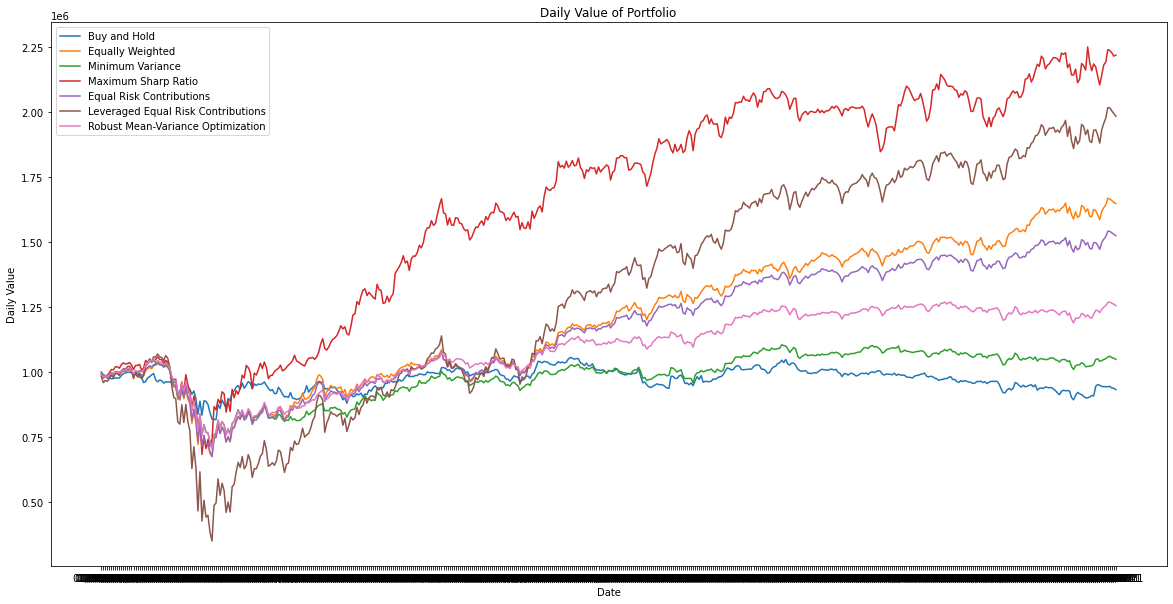

In [11]:
# Plot results
###################### Insert your code here ############################
# Daily Value of portfolio
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.xlabel("Date")
plt.ylabel("Daily Value")
plt.title("Daily Value of Portfolio")

plt.plot(dates, portf_value[0],label = "Buy and Hold")
plt.plot(dates, portf_value[1], label = "Equally Weighted")
plt.plot(dates, portf_value[2], label = "Minimum Variance")
plt.plot(dates, portf_value[3], label = "Maximum Sharp Ratio")
plt.plot(dates, portf_value[4], label = "Equal Risk Contributions")
plt.plot(dates, portf_value[5], label = "Leveraged Equal Risk Contributions")
plt.plot(dates, portf_value[6], label = "Robust Mean-Variance Optimization")

plt.legend()
plt.show

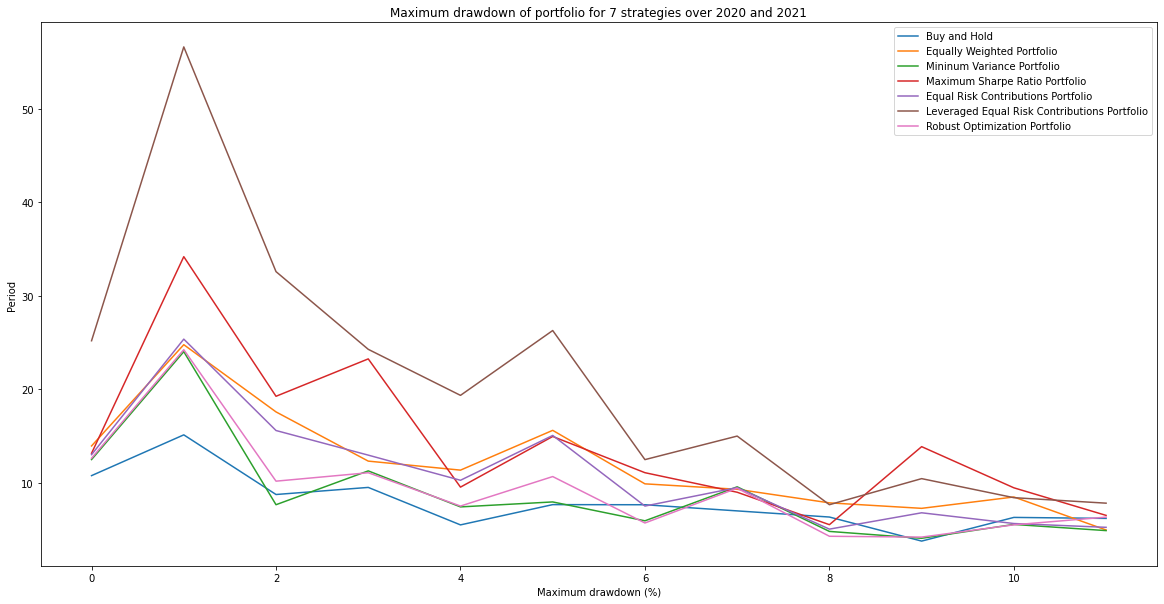

In [12]:
# Maximum drawdown of portfolio
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

plt.figure(figsize=(20,10))
for i in range(len(strategy_names)):  
    dd = []
    for j in split(portf_value[i],12):
        drawdown = abs((min(j) - max(j)) / max(j)) * 100
        dd.append(drawdown)
    
    max_dd = np.zeros(shape=(7,12))
    max_dd[i, :] = np.reshape(dd, (1,12))

    plt.plot(max_dd[i], label = strategy_names[i])
    plt.title('Maximum drawdown of portfolio for 7 strategies over 2020 and 2021')
    plt.xlabel('Maximum drawdown (%)')
    plt.ylabel('Period')
    plt.legend()

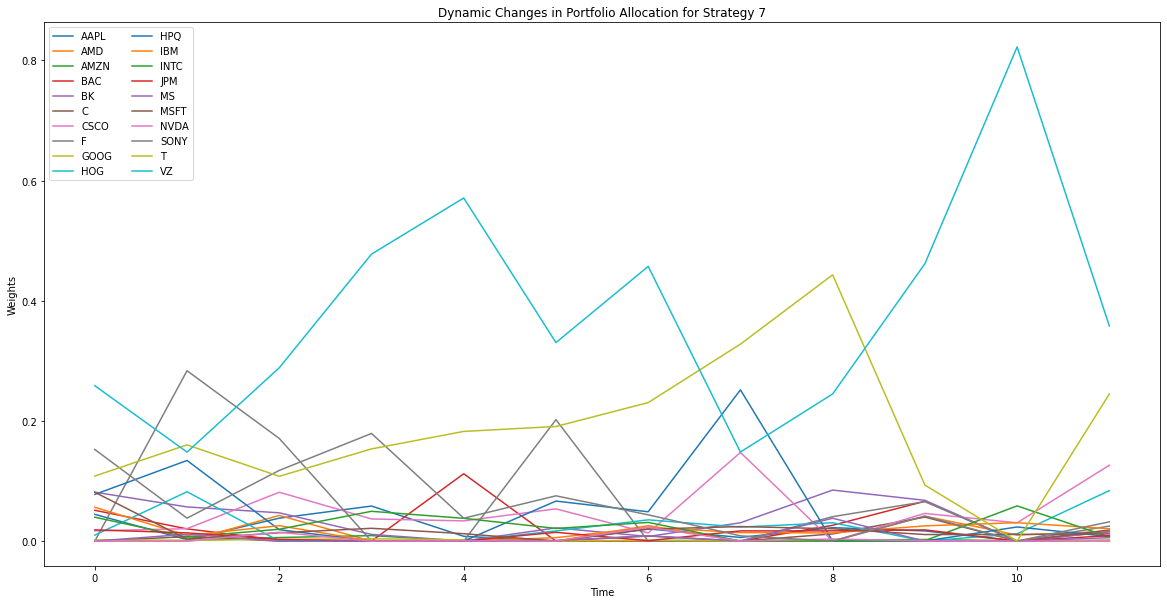

In [13]:
# Dynamic changes in portfolio allocations for strategy 7
w_strate7 = []

for period in range(1, N_periods + 1):
    w_strate7.append(x[6, period-1] / sum(x[6, period-1]))
    
df_strate7 = pd.DataFrame(np.array(w_strate7), columns=df.columns[1:])

df_strate7.plot(figsize=(20,10))
plt.title('Dynamic Changes in Portfolio Allocation for Strategy 7')
plt.xlabel('Time')
plt.ylabel('Weights')
plt.legend(ncol=2)
plt.show()

# Testing trading strategies for years 2008 and 2009

In [14]:
# Input file
input_file_prices0809 = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices0809)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
interest = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 8:
       cur_year  = 8 + math.floor(period/7)
   else:
       cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], interest[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      port_value = np.dot(cur_prices,curr_positions) + curr_cash

      if cash[strategy, period-1] < 0:
        if cash[5,0] < 0:
           port_value = (np.dot(cur_prices,curr_positions) + curr_cash) * 2

        # Calculate proportion position from whole position 
        prop = x[strategy, period-1] / np.sum(x[strategy, period-1])
        # Distribute cash by proportion
        extra_cash = abs(cash[strategy, period-1]) * prop
        # Extra position for the stocks, round up for integer value
        extra_position = np.ceil(extra_cash / cur_prices)
            
        # New position, portfolio value, transaction cost and cash
        x[strategy, period-1] = x[strategy, period-1] - extra_position
        trans_cost =  0.005 * np.dot(abs(x[strategy, period-1] - curr_positions), cur_prices)
        cash[strategy, period-1] = port_value - np.dot(cur_prices , x[strategy, period-1]) - trans_cost - interest[strategy,period-1] 
        
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      
      if strategy == 5:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value

      #portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 385097.15


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 385097.15, value end = $ 325918.34
  Strategy "Equally Weighted Portfolio", value begin = $ 381649.89, value end = $ 326929.57
  Strategy "Mininum Variance Portfolio", value begin = $ 383262.49, value end = $ 327144.09
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 381265.54, value end = $ 332652.59
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 381844.67, value end = $ 329219.26
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 377333.59, value end = $ 272026.86


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
/usr/local/lib/python3.7/dist-packages/cyipopt/utils.py:43: FutureWarning: The method named 'addOption' in class 'Problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)


  Strategy "Robust Optimization Portfolio", value begin = $ 382273.53, value end = $ 332108.58

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 325807.08, value end = $ 349997.20
  Strategy "Equally Weighted Portfolio", value begin = $ 322097.69, value end = $ 354821.22
  Strategy "Mininum Variance Portfolio", value begin = $ 322718.41, value end = $ 365547.71
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 325785.77, value end = $ 344234.61
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 324423.91, value end = $ 361277.82
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 259569.74, value end = $ 332700.37
  Strategy "Robust Optimization Portfolio", value begin = $ 328115.51, value end = $ 362108.61

Period 3: start date 05/01/2008, end date 06/30/2008
  Strategy "Buy and Hold", value begin = $ 357929.49, value end = $ 322881.56
  Strategy "Equally Weighted Portfolio", value begin = $

<function matplotlib.pyplot.show>

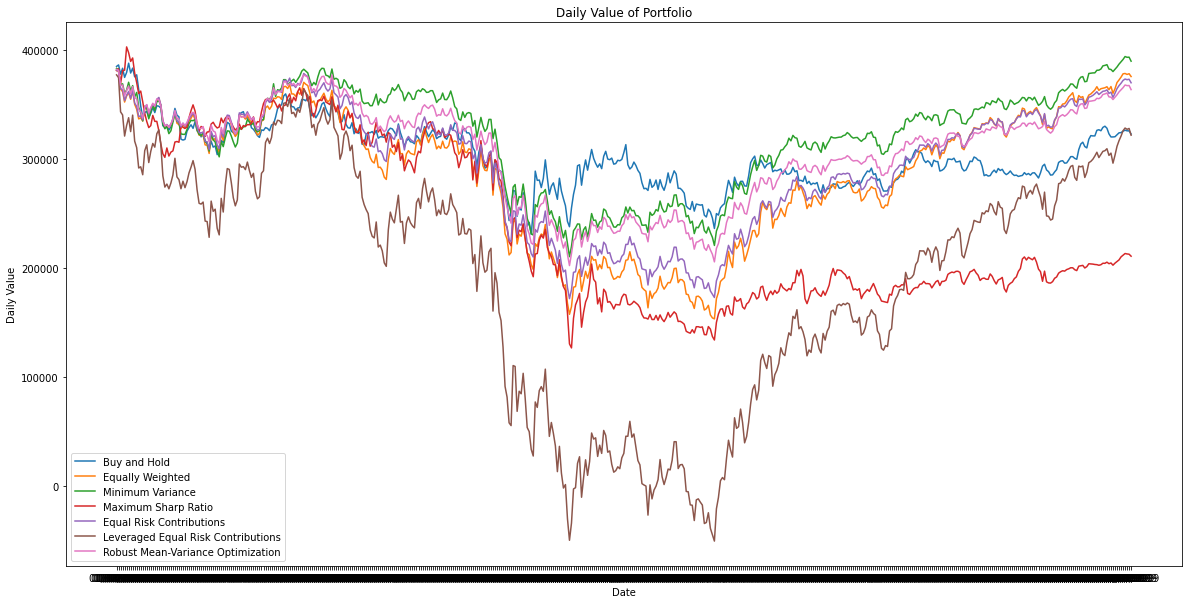

In [15]:
# Plot results
###################### Insert your code here ############################
# Daily Value of portfolio
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.xlabel("Date")
plt.ylabel("Daily Value")
plt.title("Daily Value of Portfolio")

plt.plot(dates, portf_value[0], label = "Buy and Hold")
plt.plot(dates, portf_value[1], label = "Equally Weighted")
plt.plot(dates, portf_value[2], label = "Minimum Variance")
plt.plot(dates, portf_value[3], label = "Maximum Sharp Ratio")
plt.plot(dates, portf_value[4], label = "Equal Risk Contributions")
plt.plot(dates, portf_value[5], label = "Leveraged Equal Risk Contributions")
plt.plot(dates, portf_value[6], label = "Robust Mean-Variance Optimization")

plt.legend()
plt.show

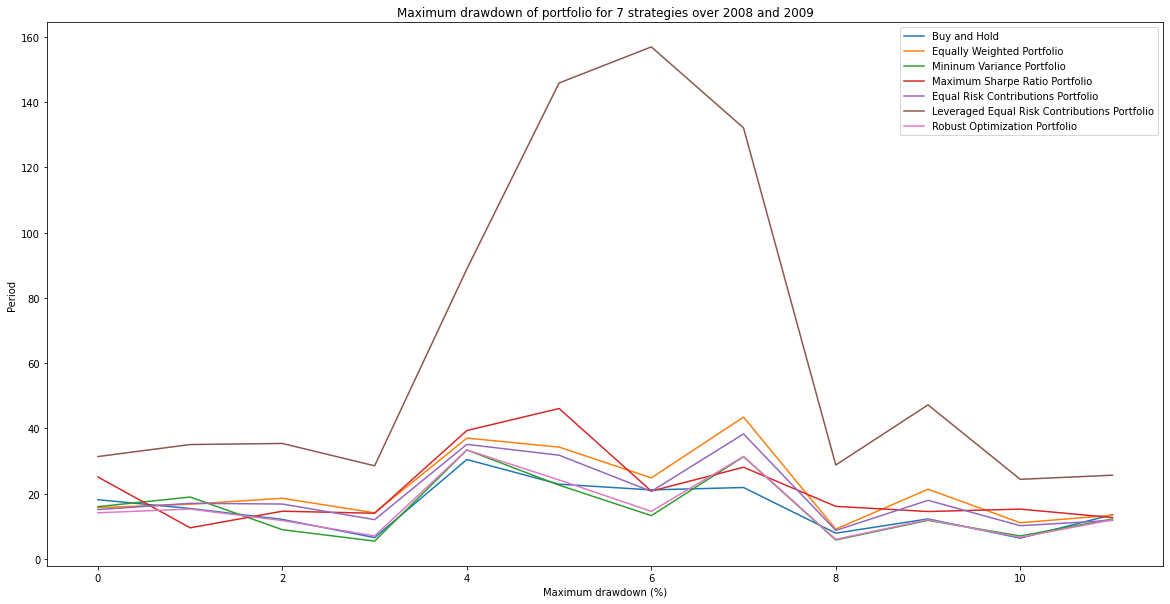

In [16]:
# Maximum drawdown of portfolio
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

plt.figure(figsize=(20,10))
for i in range(len(strategy_names)):  
    dd = []
    for j in split(portf_value[i],12):
        drawdown = abs((min(j) - max(j)) / max(j)) * 100
        dd.append(drawdown)
    
    max_dd = np.zeros(shape=(7,12))
    max_dd[i, :] = np.reshape(dd, (1,12))

    plt.plot(max_dd[i], label = strategy_names[i])
    plt.title('Maximum drawdown of portfolio for 7 strategies over 2008 and 2009')
    plt.xlabel('Maximum drawdown (%)')
    plt.ylabel('Period')
    plt.legend()

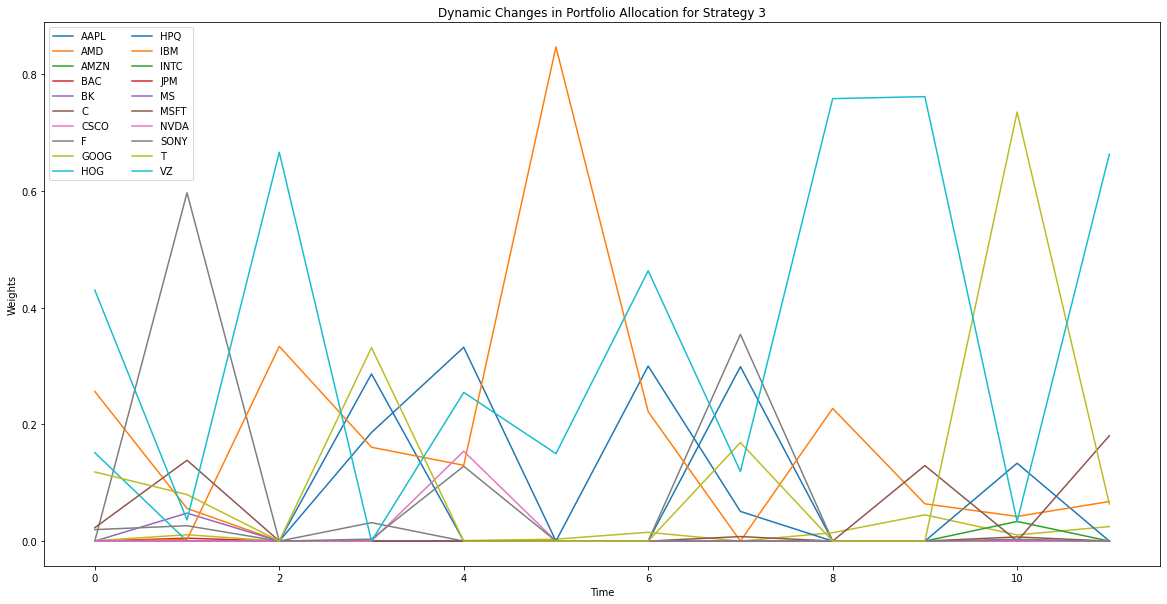

In [17]:
# Dynamic changes in portfolio allocations for strategy 3
w_strate3 = []

for period in range(1, N_periods + 1):
    w_strate3.append(x[2, period-1] / sum(x[2, period-1]))
    
df_strate3 = pd.DataFrame(np.array(w_strate3), columns=df.columns[1:])

df_strate3.plot(figsize=(20,10))
plt.title('Dynamic Changes in Portfolio Allocation for Strategy 3')
plt.xlabel('Time')
plt.ylabel('Weights')
plt.legend(ncol=2)
plt.show()

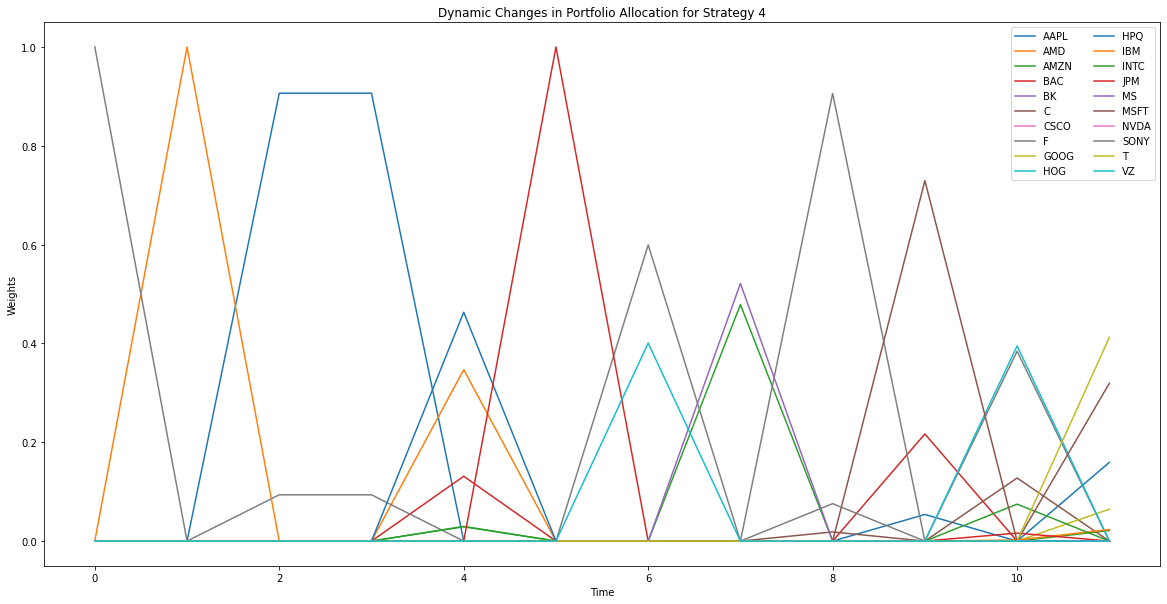

In [18]:
# Dynamic changes in portfolio allocations for strategy 4
w_strate4 = []

for period in range(1, N_periods + 1):
    w_strate4.append(x[3, period-1] / sum(x[3, period-1]))
    
df_strate4 = pd.DataFrame(np.array(w_strate4), columns=df.columns[1:])

df_strate4.plot(figsize=(20,10))
plt.title('Dynamic Changes in Portfolio Allocation for Strategy 4')
plt.xlabel('Time')
plt.ylabel('Weights')
plt.legend(ncol=2)
plt.show()

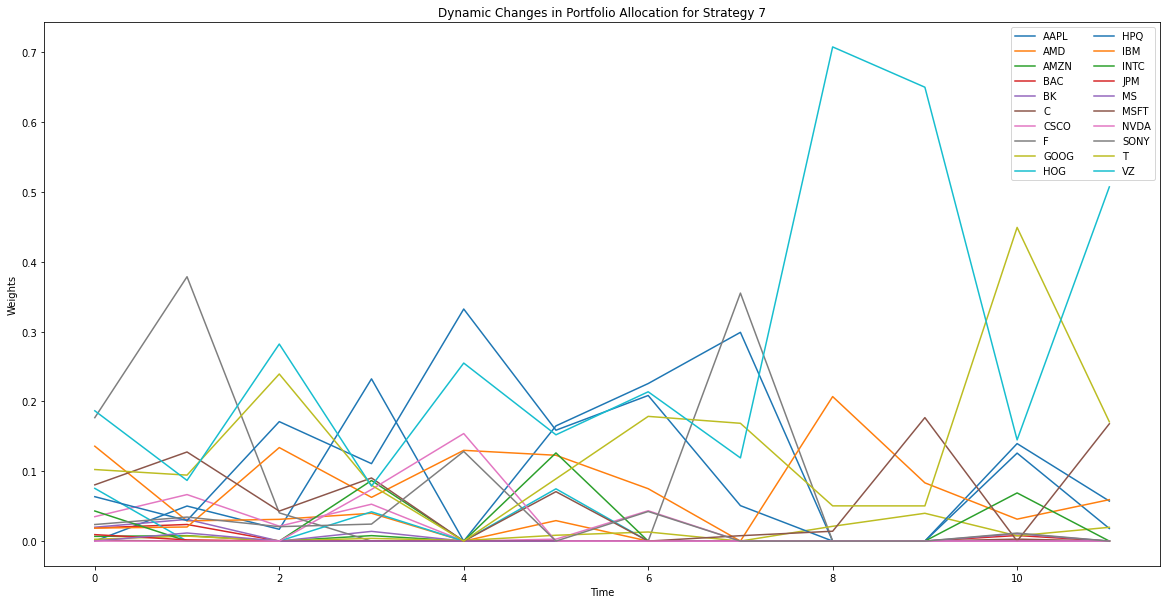

In [19]:
# Dynamic changes in portfolio allocations for strategy 7
w_strate7 = []

for period in range(1, N_periods + 1):
    w_strate7.append(x[6, period-1] / sum(x[6, period-1]))
    
df_strate7 = pd.DataFrame(np.array(w_strate7), columns=df.columns[1:])

df_strate7.plot(figsize=(20,10))
plt.title('Dynamic Changes in Portfolio Allocation for Strategy 7')
plt.xlabel('Time')
plt.ylabel('Weights')
plt.legend(ncol=2)
plt.show()

Reference:
https://www.codegrepper.com/code-examples/python/python+divide+array+into+n+parts